In [1]:
import cv2

import numpy as np
np.random.seed(1)

import os
import pandas as pd
import itertools
import random
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

In [2]:
#Get dataset directories
train_dir = Path('./data/training/training/')
val_dir = Path('./data/validation/validation/')

In [3]:
#Get class labels
labels = pd.read_csv("./data/monkey_labels.txt").rename(columns=lambda x: x.strip())
labels = labels['Common Name']

In [4]:
#Hyper Parameters
LR = 1e-3
height=150
width=150
batch_size = 64
epochs = 200

#Constants
seed=1337
channels=3
num_classes = 10

# Training generator. This creates batches of augmented training image data.
# This augmentation includes rotating, shifting, and flipping images to reduce overfitting.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(height,width),
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode='categorical'
)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    val_dir, 
    target_size=(height,width), 
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode='categorical'
)

train_num = train_generator.samples
validation_num = validation_generator.samples 

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [5]:
#Create the model architecture. This consists of a set of Convolution,
#ReLU, MaxPooling, DropOut(Training only), and Fully-Connected layers.
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(height, width, channels)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [6]:
#Compile model
model.compile(optimizer=Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                   

In [7]:
#Create callbacks for saving the model and concelling training if no progress is being made
filepath=str(os.getcwd()+"/model.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
stopper = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint, stopper]

In [8]:
#Train model
history = model.fit(
    train_generator,
    steps_per_epoch= train_num // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps= validation_num // batch_size,
    callbacks=callbacks_list, 
    verbose = 1
)

Epoch 1/200
17/17 [==============================] - ETA: 0s - loss: 2.2410 - acc: 0.1772
Epoch 1: val_acc improved from -inf to 0.26562, saving model to C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f
INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 34s 2s/step - loss: 2.2410 - acc: 0.1772 - val_loss: 2.0581 - val_acc: 0.2656
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 1.9669 - acc: 0.2914
Epoch 2: val_acc improved from 0.26562 to 0.37891, saving model to C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f
INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 32s 2s/step - loss: 1.9669 - acc: 0.2914 - val_loss: 1.7739 - val_acc: 0.3789
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 1.8759 - acc: 0.3214
Epoch 3: val_acc improved from 0.37891 to 0.48047, saving model to C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f
INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 32s 2s/step - loss: 1.8759 - acc: 0.3214 - val_loss: 1.5820 - val_acc: 0.4805
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss: 1.6704 - acc: 0.4114
Epoch 4: val_acc improved from 0.48047 to 0.53516, saving model to C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f
INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 32s 2s/step - loss: 1.6704 - acc: 0.4114 - val_loss: 1.4248 - val_acc: 0.5352
Epoch 5/200
17/17 [==============================] - ETA: 0s - loss: 1.5562 - acc: 0.4540
Epoch 5: val_acc did not improve from 0.53516
17/17 [==============================] - 31s 2s/step - loss: 1.5562 - acc: 0.4540 - val_loss: 1.3454 - val_acc: 0.5312
Epoch 6/200
17/17 [==============================] - ETA: 0s - loss: 1.5425 - acc: 0.4395
Epoch 6: val_acc improved from 0.53516 to 0.57422, saving model to C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f
INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 33s 2s/step - loss: 1.5425 - acc: 0.4395 - val_loss: 1.3324 - val_acc: 0.5742
Epoch 7/200
17/17 [==============================] - ETA: 0s - loss: 1.4581 - acc: 0.4705
Epoch 7: val_acc did not improve from 0.57422
17/17 [==============================] - 33s 2s/step - loss: 1.4581 - acc: 0.4705 - val_loss: 1.3825 - val_acc: 0.4766
Epoch 8/200
17/17 [==============================] - ETA: 0s - loss: 1.4211 - acc: 0.5073
Epoch 8: val_acc did not improve from 0.57422
17/17 [==============================] - 32s 2s/step - loss: 1.4211 - acc: 0.5073 - val_loss: 1.5496 - val_acc: 0.4648
Epoch 9/200
17/17 [==============================] - ETA: 0s - loss: 1.4978 - acc: 0.4647
Epoch 9: val_acc improved from 0.57422 to 0.58203, saving model to C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f
INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 34s 2s/step - loss: 1.4978 - acc: 0.4647 - val_loss: 1.2844 - val_acc: 0.5820
Epoch 10/200
17/17 [==============================] - ETA: 0s - loss: 1.3621 - acc: 0.4947
Epoch 10: val_acc did not improve from 0.58203
17/17 [==============================] - 32s 2s/step - loss: 1.3621 - acc: 0.4947 - val_loss: 1.2761 - val_acc: 0.5625
Epoch 11/200
17/17 [==============================] - ETA: 0s - loss: 1.3252 - acc: 0.5198
Epoch 11: val_acc did not improve from 0.58203
17/17 [==============================] - 31s 2s/step - loss: 1.3252 - acc: 0.5198 - val_loss: 1.2812 - val_acc: 0.5508
Epoch 12/200
17/17 [==============================] - ETA: 0s - loss: 1.3409 - acc: 0.4985
Epoch 12: val_acc did not improve from 0.58203
17/17 [==============================] - 31s 2s/step - loss: 1.3409 - acc: 0.4985 - val_loss: 1.2373 - val_acc: 0.5703
Epoch 13/200
17/17 [==============================] - ETA: 0s - loss: 1.2944 - acc: 0.5266
Epoch 13: val_acc i

INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 32s 2s/step - loss: 1.2944 - acc: 0.5266 - val_loss: 1.2049 - val_acc: 0.5898
Epoch 14/200
17/17 [==============================] - ETA: 0s - loss: 1.3534 - acc: 0.5063
Epoch 14: val_acc improved from 0.58984 to 0.60156, saving model to C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f
INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 33s 2s/step - loss: 1.3534 - acc: 0.5063 - val_loss: 1.1421 - val_acc: 0.6016
Epoch 15/200
17/17 [==============================] - ETA: 0s - loss: 1.2539 - acc: 0.5440
Epoch 15: val_acc did not improve from 0.60156
17/17 [==============================] - 33s 2s/step - loss: 1.2539 - acc: 0.5440 - val_loss: 1.2458 - val_acc: 0.5898
Epoch 16/200
17/17 [==============================] - ETA: 0s - loss: 1.2525 - acc: 0.5363
Epoch 16: val_acc did not improve from 0.60156
17/17 [==============================] - 32s 2s/step - loss: 1.2525 - acc: 0.5363 - val_loss: 1.2218 - val_acc: 0.5820
Epoch 17/200
17/17 [==============================] - ETA: 0s - loss: 1.2139 - acc: 0.5566
Epoch 17: val_acc did not improve from 0.60156
17/17 [==============================] - 33s 2s/step - loss: 1.2139 - acc: 0.5566 - val_loss: 1.3726 - val_acc: 0.5195
Epoch 18/200
17/17 [==============================] - ETA: 0s - loss: 1.1906 - acc: 0.5547
Epoch 18: val_acc d

INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 33s 2s/step - loss: 1.1182 - acc: 0.6128 - val_loss: 1.0735 - val_acc: 0.6328
Epoch 21/200
17/17 [==============================] - ETA: 0s - loss: 1.1750 - acc: 0.5721
Epoch 21: val_acc did not improve from 0.63281
17/17 [==============================] - 31s 2s/step - loss: 1.1750 - acc: 0.5721 - val_loss: 1.1158 - val_acc: 0.6250
Epoch 22/200
17/17 [==============================] - ETA: 0s - loss: 1.1336 - acc: 0.5973
Epoch 22: val_acc did not improve from 0.63281
17/17 [==============================] - 31s 2s/step - loss: 1.1336 - acc: 0.5973 - val_loss: 1.3579 - val_acc: 0.5508
Epoch 23/200
17/17 [==============================] - ETA: 0s - loss: 1.1854 - acc: 0.5770
Epoch 23: val_acc did not improve from 0.63281
17/17 [==============================] - 31s 2s/step - loss: 1.1854 - acc: 0.5770 - val_loss: 1.3868 - val_acc: 0.5352
Epoch 24/200
17/17 [==============================] - ETA: 0s - loss: 1.1420 - acc: 0.5886
Epoch 24: val_acc d

INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 32s 2s/step - loss: 1.0201 - acc: 0.6244 - val_loss: 0.9004 - val_acc: 0.7109
Epoch 32/200
17/17 [==============================] - ETA: 0s - loss: 0.9002 - acc: 0.6660
Epoch 32: val_acc did not improve from 0.71094
17/17 [==============================] - 30s 2s/step - loss: 0.9002 - acc: 0.6660 - val_loss: 1.0539 - val_acc: 0.6680
Epoch 33/200
17/17 [==============================] - ETA: 0s - loss: 0.9965 - acc: 0.6399
Epoch 33: val_acc did not improve from 0.71094
17/17 [==============================] - 31s 2s/step - loss: 0.9965 - acc: 0.6399 - val_loss: 1.3444 - val_acc: 0.5508
Epoch 34/200
17/17 [==============================] - ETA: 0s - loss: 0.9896 - acc: 0.6350
Epoch 34: val_acc did not improve from 0.71094
17/17 [==============================] - 31s 2s/step - loss: 0.9896 - acc: 0.6350 - val_loss: 1.0470 - val_acc: 0.6484
Epoch 35/200
17/17 [==============================] - ETA: 0s - loss: 1.0145 - acc: 0.6370
Epoch 35: val_acc d

INFO:tensorflow:Assets written to: C:\Users\Joe\Documents\Imperial AI\Capstone\CapstoneProject\model.h5f\assets


17/17 [==============================] - 33s 2s/step - loss: 0.9072 - acc: 0.6805 - val_loss: 0.8013 - val_acc: 0.7578
Epoch 38/200
17/17 [==============================] - ETA: 0s - loss: 0.8444 - acc: 0.6941
Epoch 38: val_acc did not improve from 0.75781
17/17 [==============================] - 32s 2s/step - loss: 0.8444 - acc: 0.6941 - val_loss: 1.0841 - val_acc: 0.6641
Epoch 39/200
17/17 [==============================] - ETA: 0s - loss: 0.8443 - acc: 0.6999
Epoch 39: val_acc did not improve from 0.75781
17/17 [==============================] - 32s 2s/step - loss: 0.8443 - acc: 0.6999 - val_loss: 0.9340 - val_acc: 0.7109
Epoch 40/200
17/17 [==============================] - ETA: 0s - loss: 0.9754 - acc: 0.6292
Epoch 40: val_acc did not improve from 0.75781
17/17 [==============================] - 32s 2s/step - loss: 0.9754 - acc: 0.6292 - val_loss: 1.2109 - val_acc: 0.6133
Epoch 41/200
17/17 [==============================] - ETA: 0s - loss: 0.9186 - acc: 0.6902
Epoch 41: val_acc d

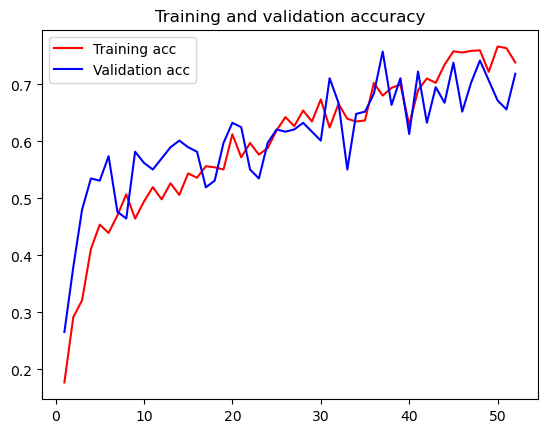

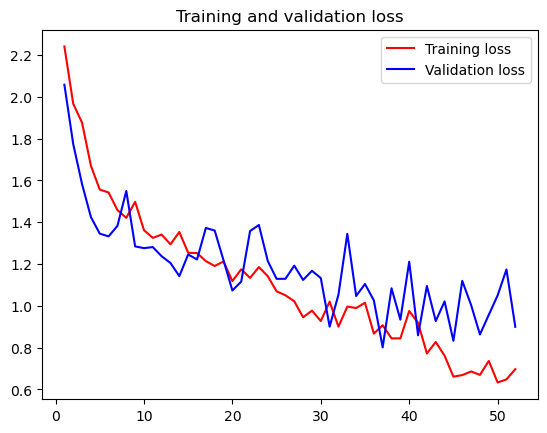

In [9]:
#Plot learning history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [10]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

5/5 [==============================] - 5s 1s/step


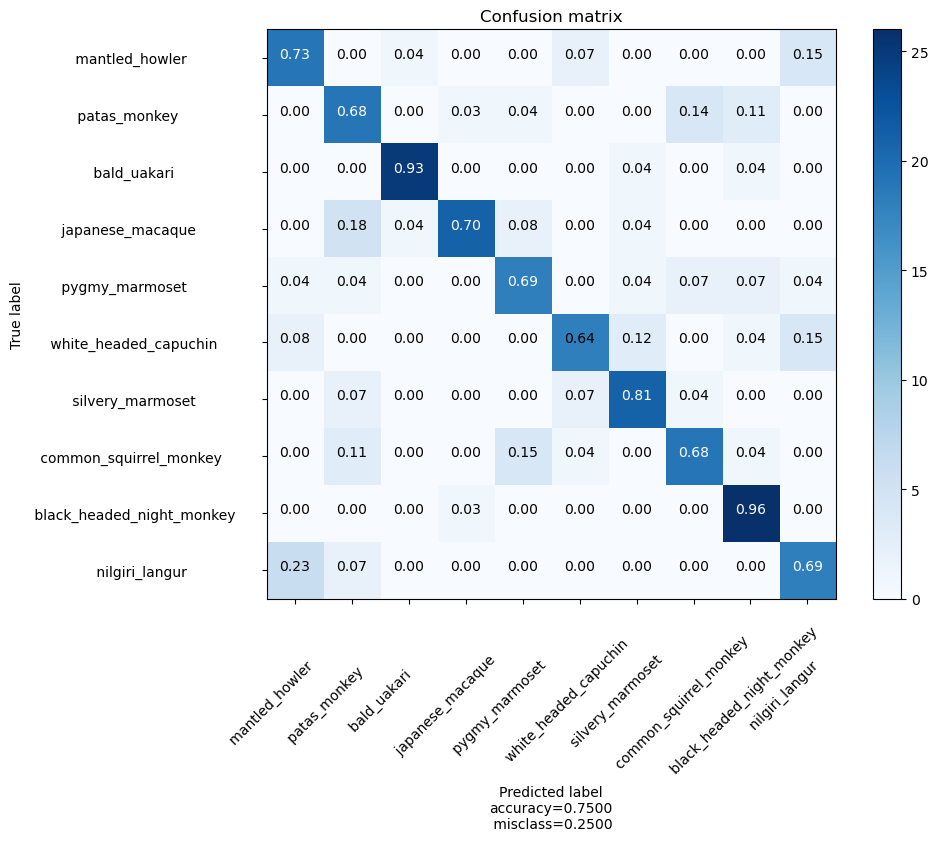

In [13]:
model_trained = load_model(filepath)
# Predict the values from the validation dataset
Y_pred = model_trained.predict(validation_generator, validation_num // batch_size+1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [12]:
print(classification_report(validation_generator.classes, Y_pred_classes,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       0.68      0.73      0.70        26
 patas_monkey                         0.59      0.68      0.63        28
 bald_uakari                          0.93      0.93      0.93        27
 japanese_macaque                     0.91      0.70      0.79        30
 pygmy_marmoset                       0.72      0.69      0.71        26
 white_headed_capuchin                0.78      0.64      0.71        28
 silvery_marmoset                     0.78      0.81      0.79        26
 common_squirrel_monkey               0.73      0.68      0.70        28
 black_headed_night_monkey            0.76      0.96      0.85        27
 nilgiri_langur                       0.67      0.69      0.68        26

                       accuracy                           0.75       272
                      macro avg       0.76      0.75      0.75       272
                   weighted avg       0.76      0